![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
class BoxAnalysis():
    '''Вох анализ с основными показателями'''

    def __init__(self, df, column):
        self.df = df
        self.column = column

    def perc25(self):
        return self.df[self.column].quantile(0.25)

    def perc75(self):
        return self.df[self.column].quantile(0.75)

    def iqr(self):
        return self.perc75() - self.perc25()

    def left(self):
        return self.perc25() - 1.5 * self.iqr()

    def right(self):
        return self.perc75() + 1.5 * self.iqr()

    def __str__(self):
        return '25%: {}, 75%: {}, IQR: {}, Range: [{}, {}].'.format(
            self.perc25(), self.perc75(), self.iqr(),
            self.left(), self.right())

    def __repr__(self):
        return self.__str__()

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Всего в данных содержится 10 полей, три из них числовые. 7 полей не содержат пропуски, 4 содержит: Cuisine Style, Price Range, Number of Reviews, Reviews.

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
294,id_294,Budapest,NaN,2231.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274887-d10748374-Reviews-F...,d10748374,0,0.0
24407,id_528,Lyon,"['Barbecue', 'Asian', 'Korean', 'Vegetarian Fr...",529.0,$$ - $$$,91.0,"[['Modest portions', 'AMAZING !'], ['10/12/201...",/Restaurant_Review-g187265-d4556074-Reviews-Le...,d4556074,1,4.0
14186,id_12501,London,"['Italian', 'French', 'Cafe', 'European', 'Bri...",12511.0,$,NaN,"[['Great simple place. Fine food'], ['06/17/20...",/Restaurant_Review-g186338-d10458829-Reviews-B...,d10458829,1,4.0
30706,id_4340,Barcelona,"['Cafe', 'Mediterranean', 'Spanish']",4341.0,$,NaN,"[[], []]",/Restaurant_Review-g187497-d6022580-Reviews-Ba...,d6022580,1,5.0
15480,id_3215,Paris,['French'],3216.0,$$ - $$$,39.0,"[['great food, nice ambience, friendly servic....",/Restaurant_Review-g187147-d8755509-Reviews-Lo...,d8755509,1,4.5


In [15]:
data.iloc[1]

Restaurant_id                                                     id_1
City                                                          Helsinki
Cuisine Style        ['European', 'Scandinavian', 'Gluten Free Opti...
Ranking                                                            106
Price Range                                                   $$ - $$$
Number of Reviews                                                   97
Reviews              [['Very good reviews!', 'Fine dining in Hakani...
URL_TA               /Restaurant_Review-g189934-d6674944-Reviews-Ra...
ID_TA                                                         d6674944
sample                                                               0
Rating                                                               0
Name: 1, dtype: object

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [16]:
sorted(df_train['Rating'].unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Посмотрим на нашу ключевую переменную. Всего 9 значений, интервал между значениями 0.5

# Cleaning and Prepping Data

Для быстрого рассчета и контороля MAE создадим список подготовленных столбцов, будем обновлять его по ходу дела, и сразу же проверять результат по выбранным полям

In [17]:
prepared_columns = set(['Rating'])

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [18]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')
# положительно влияет на итоговое значение
prepared_columns.add('Number_of_Reviews_isNAN')
# prepared_columns.add('Price_Range_isNAN')
# prepared_columns.add('Cuisine_Style_isNAN')
# prepared_columns.add('Reviews_isNAN')

### 2. Обработка признаков

#### Price Range

Переименуем для удобства использования

In [19]:
data.rename(columns={'Price Range': 'Price_Range'}, inplace=True)
data['Price_Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [20]:
data['Price_Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

Содержится всего 3 значения. Из символов легко понять, в каком порядке происходит возрастание. Обсолютное большинство ресторанов в среднем ценовом диапазоне, заменим пропуски средним ценовым диапазоном. Создадим новое поле, для того, что бы сохранить информацию о пропусках.

In [21]:
data['Price_Range'].fillna('$$ - $$$', inplace=True)

Заменим значения на числовые значения от 1 до 3

In [22]:
data['Price_Range'] = data['Price_Range'].map({'$': 1, '$$ - $$$': 2, '$$$$': 3})

In [23]:
# добавляем итоговый набор колонок
prepared_columns.add('Price_Range')

#### City

In [24]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Пропусков нет. Городов не так много, заменим все значение на dummy столбцы

In [25]:
dummies_city = pd.get_dummies(data['City'])
data = pd.concat([data, pd.get_dummies(dummies_city)], axis=1)

In [26]:
prepared_columns.update(dummies_city.columns.tolist())

#### Cuisine Style

Переименуем для удобства использования. Создадим regex паттерн для поиска типов кухонь в представленном наборе данных

In [27]:
data.rename(columns={'Cuisine Style': 'Cuisine_Style'}, inplace=True)
cuisine_pattern = re.compile("'([a-z]+.*?[a-z]*)'")

Заполним пропуски значением "['other']"

In [28]:
data['Cuisine_Style'].fillna("['other']", inplace=True)

Преобразуем поле Cuisine_Style из строки в список содержащий все типы кухонь в ресторане

In [29]:
data['Cuisine_Style'] = data['Cuisine_Style'].apply(
    lambda x: cuisine_pattern.findall(x.lower()))

In [30]:
all_cusines = []

for v in data['Cuisine_Style'].tolist():
    all_cusines.extend(v)
    
cusine_counts = Counter(all_cusines)
cusine_counts.most_common(2)

[('vegetarian friendly', 14021), ('european', 12561)]

Создали dummy поля для каждого ресторана и типа кухонь в нем

In [31]:
for c in cusine_counts:
    data[c] = data['Cuisine_Style'].apply(lambda x: 1 if c in x else 0)

In [32]:
prepared_columns.update(cusine_counts.keys())

#### Number of Reviews

In [33]:
data.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

Заменим пустые значения средним

In [34]:
data['Number_of_Reviews'].fillna(data['Number_of_Reviews'].mean(), inplace=True)

#### Reviews

Заменим пустые значения пустыми строками

In [35]:
data['Reviews'].fillna('', inplace=True)

In [36]:
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Столбец представляет из себя строку в которой два списка. В одном сами обзоры, во втором даты написания.

In [37]:
def date_from_string(date_str):
    first = '%m'
    second = '%d'
    third = '%Y'
    if int(date_str.split('/')[0]) > 12:
        tmp = second
        second = first
        first = tmp
    if len(date_str.split('/')[-1]) == 2:
        third = '%y'
    return datetime.strptime(date_str, '/'.join([first, second, third]))

Создадим новое поле, которое будет содержать даты обзоров.

In [38]:
data['Reviews_Dates'] = data['Reviews'].str.findall('\d+/\d+/\d+').apply(
    lambda x: sorted([date_from_string(date_str) for date_str in x], reverse=True))

# EDA 

### Посмотрим распределение признака

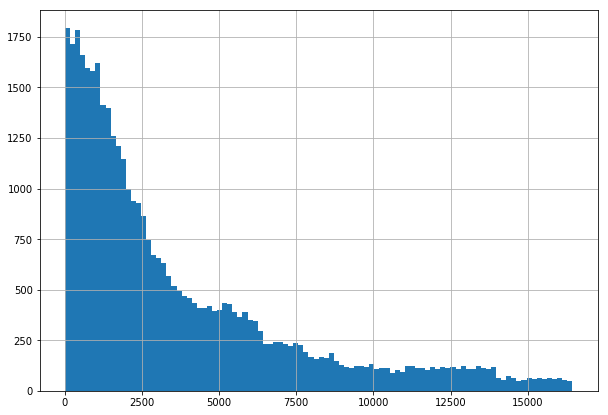

In [39]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

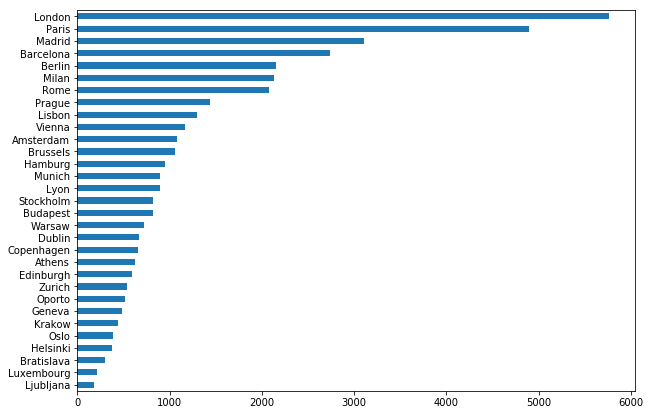

In [40]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

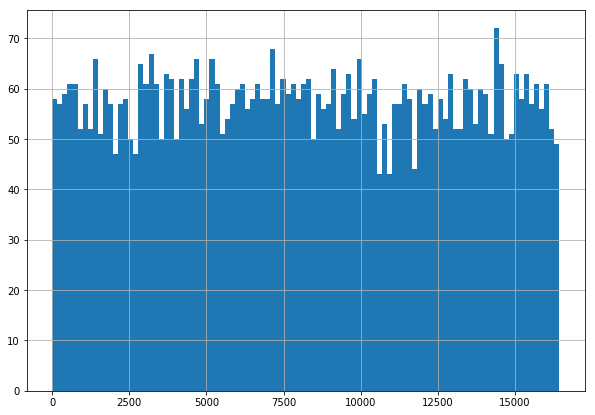

In [41]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

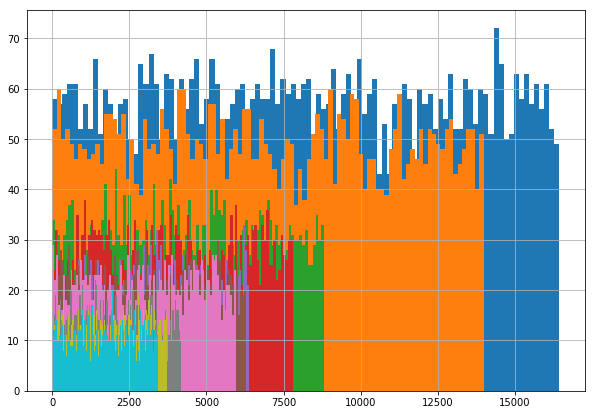

In [42]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. Необходимо отнормировать Ranking по городам.

In [43]:
data['City_Restaurants'] = data['City'].map(
        data.groupby(['City'])['Restaurant_id'].count().to_dict())
mean_city_ranking = data.groupby(['City'])['Ranking'].mean()


data['Mean_City_Ranking'] = data['City'].apply(lambda x: mean_city_ranking[x])
data['Norm_City_Ranking'] = (data['Ranking'] - data['Mean_City_Ranking']) / data['City_Restaurants'] 
data['Ranking'] = StandardScaler().fit_transform(data[['Ranking']])

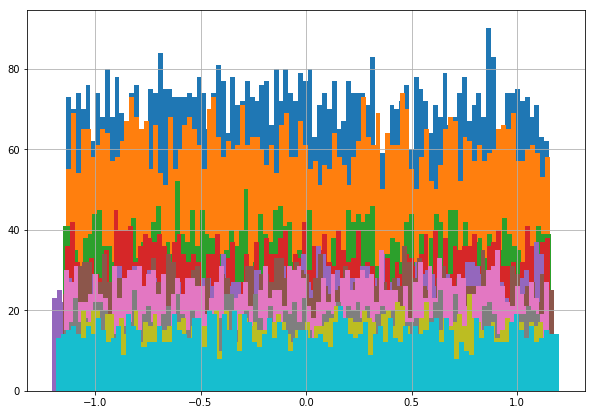

In [44]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Norm_City_Ranking'][data['City'] == x].hist(bins=100)
plt.show()

In [45]:
prepared_columns.add('Norm_City_Ranking')
prepared_columns.add('Ranking')
# prepared_columns.add('Mean_City_Ranking')

Посмотрим выбросы для Number_of_Reviews

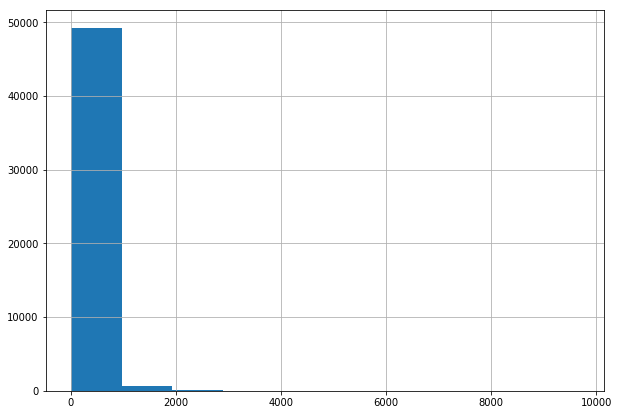

In [46]:
data['Number_of_Reviews'].hist()

In [47]:
b_analysis = BoxAnalysis(data, 'Number_of_Reviews')
b_analysis

25%: 10.0, 75%: 124.47119658119658, IQR: 114.47119658119658, Range: [-161.70679487179487, 296.1779914529915].

Есть выбросы заменим все значение больше правой границы на значения правой границы

In [48]:
data.loc[data['Number_of_Reviews'] > b_analysis.right(), 
         'Number_of_Reviews'] = round(b_analysis.right())

In [49]:
prepared_columns.add('Number_of_Reviews')

Посмотрим на Reviews

Создадим поле, которое содержит количество отображаемых обзоров

In [50]:
data['Number_of_Visible_Reviews'] = data['Reviews_Dates'].apply(lambda x: len(x))

In [51]:
# кол-во строк с двумя отзывами
data[data['Number_of_Visible_Reviews'] == 2]['Number_of_Visible_Reviews'].count()

36202

In [52]:
# кол-во строк без отзывов
data[data['Number_of_Visible_Reviews'] == 0]['Number_of_Visible_Reviews'].count()

8114

In [53]:
# кол-во строк с одним отзывом
data[data['Number_of_Visible_Reviews'] == 1]['Number_of_Visible_Reviews'].count()

5680

In [54]:
# кол-во строк с более чем двумя отзывами
data[data['Number_of_Visible_Reviews'] > 2]['Number_of_Visible_Reviews'].count()

4

In [55]:
data[data['Number_of_Visible_Reviews'] > 2][['Reviews_Dates', 'Reviews']]

,Reviews_Dates,Reviews
2221,"[2017-12-22 00:00:00, 2017-10-21 00:00:00, 201...","[['We visited 21/10/17', 'Best Kebab in London..."
3809,"[2017-05-30 00:00:00, 2017-05-30 00:00:00, 201...","[['Good Museum Cafeteria', 'Lunch 30/5/2017'],..."
19254,"[2017-06-02 00:00:00, 2017-03-01 00:00:00, 201...","[['The desserts arcade !', 'Visit today 3/1/20..."
33348,"[2016-09-30 00:00:00, 2016-09-29 00:00:00, 201...","[['lunch 29/9/2016', 'Unplanned Great Dinner']..."


Большое количество строк без отзывов. Есть строки с тремя отзывавами. Поскольку неизвестно на какую дату были выгружены данные, возьмем последнюю дату отзыва в качестве даты выгрузки.

In [56]:
latest_review = datetime(2000, 1, 1, 0, 0)
for dates in data['Reviews_Dates']:
    if (len(dates) == 0):
        continue
    temp_max = max(dates)
    if temp_max > latest_review:
        latest_review = temp_max

latest_review

datetime.datetime(2018, 2, 26, 0, 0)

Посмотрим максимальную разницу дней между двумя отзывами.

In [57]:
max([(x[0] - x[1]).days for x in data['Reviews_Dates'] if len(x) > 1])

3296

Добавим новое поле, которое будет содержать интервал в днях между двумя отзывами. Создадим поле, в котором пометим пропуски, заполним пропуски медианой.

In [58]:
data['Number_of_Days_Between_Reviews'] = data['Reviews_Dates'].apply(
    lambda x: (x[0] - x[1]).days if len(x) > 1 else None)

In [59]:
data['Number_of_Days_Between_Reviews_isNAN'] = pd.isna(
    data['Number_of_Days_Between_Reviews']).astype('uint8')

In [60]:
data['Number_of_Days_Between_Reviews'].fillna(
    data['Number_of_Days_Between_Reviews'].median(), inplace=True)

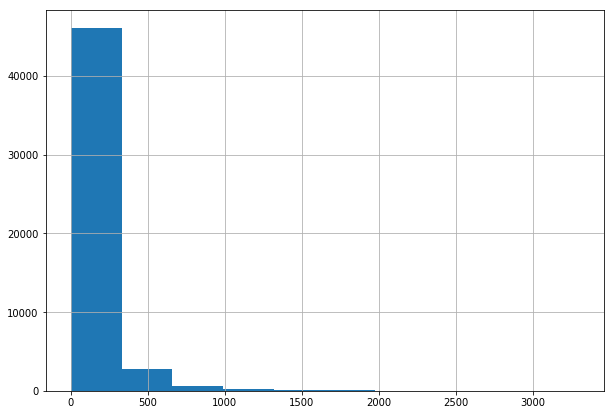

In [61]:
data['Number_of_Days_Between_Reviews'].hist()

In [62]:
b_analysis = BoxAnalysis(data, 'Number_of_Days_Between_Reviews')
b_analysis

25%: 34.0, 75%: 120.0, IQR: 86.0, Range: [-95.0, 249.0].

Заменим значения правой границы на значение правой границы

In [63]:
data.loc[data['Number_of_Days_Between_Reviews'] > b_analysis.right(),
         'Number_of_Days_Between_Reviews'] = round(b_analysis.right())

Добавим поле с количеством дней с последнего коментария и предполагаемой датой выгрузки. Создадим признак, в котором пометим пропуски, заполним пустые значения медианой.

In [64]:
data['Days_from_Last_Review'] = data['Reviews_Dates'].apply(
    lambda x: (latest_review - x[0]).days if len(x) > 0 else None)

In [65]:
data['Days_from_Last_Review_isNAN'] = pd.isna(data['Days_from_Last_Review']).astype('uint8')
data['Days_from_Last_Review'].fillna(data['Days_from_Last_Review'].median(), inplace=True)

In [66]:
prepared_columns.add('Number_of_Days_Between_Reviews')
prepared_columns.add('Days_from_Last_Review')
# prepared_columns.add('Number_of_Days_Between_Reviews_isNAN')
prepared_columns.add('Days_from_Last_Review_isNAN')

Попробеум разделить обзоры на плохие и хорошие. Найдем все слова больше 2 символов

In [67]:
all_words_counter = Counter()

for words in data['Reviews'].str.lower().str.findall("[a-zA-Z]+"):
    all_words_counter.update(filter(lambda x: len(x) > 2, words))

all_words_counter.most_common()

[('food', 13166),
 ('good', 11780),
 ('great', 10628),
 ('and', 9765),
 ('the', 6187),
 ('nice', 5702),
 ('place', 5166),
 ('for', 4803),
 ('service', 4383),
 ('very', 4208),
 ('restaurant', 3632),
 ('best', 3411),
 ('excellent', 3261),
 ('lunch', 2694),
 ('but', 2559),
 ('with', 2534),
 ('delicious', 2164),
 ('not', 2102),
 ('friendly', 1917),
 ('pizza', 1787),
 ('lovely', 1782),
 ('amazing', 1771),
 ('tasty', 1681),
 ('dinner', 1584),
 ('italian', 1378),
 ('little', 1300),
 ('bar', 1298),
 ('atmosphere', 1284),
 ('staff', 1233),
 ('meal', 1171),
 ('breakfast', 1127),
 ('experience', 1110),
 ('local', 1068),
 ('value', 1058),
 ('you', 994),
 ('coffee', 980),
 ('fantastic', 967),
 ('authentic', 946),
 ('average', 934),
 ('quick', 904),
 ('quality', 903),
 ('price', 883),
 ('perfect', 882),
 ('cafe', 831),
 ('wonderful', 815),
 ('pub', 808),
 ('this', 799),
 ('cheap', 798),
 ('sushi', 793),
 ('gem', 750),
 ('really', 743),
 ('bad', 718),
 ('fresh', 703),
 ('location', 689),
 ('beer', 68

Составим списки из однозначно плохих и хороших слов, использование которых могут с большой вероятностью охарактеризовать обзор

In [68]:
positive_words = ['excellent', 'best', 'amazing', 'fantastic',
           'perfect', 'wonderful', 'gem', 'awesome', 'superb', 
            'cool', 'fabulous', 'brilliant', 'outstanding',
           'wow', 'delightful', 'incredible', 'exceptional', 'gorgeous']


negative_words = ['bad', 'poor', 'disappoint', 'worst', 'terrible', 
                  'rude', 'awful', 'horrible', 
                  'unfriendly', 'shame', 'disgusting']

def is_positive(review):
    for word in positive_words:
        if word in review:
            return 1
    return 0


def is_negative(review):
    for word in negative_words:
        if word in review:
            return 1
    return 0
    
data['Positive_Reviews'] = data['Reviews'].apply(is_positive)
data['Negative_Reviews'] = data['Reviews'].apply(is_negative)

prepared_columns.add('Positive_Reviews')
prepared_columns.add('Negative_Reviews')

Добавим население городов из выборки, рассчитаем кол-во ресторанов на одного человека

In [69]:
city_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}

data['City_Population'] = data['City'].map(city_population)
data['Restaurants_per_Person'] = data['City_Restaurants']/data['City_Population']
data['City_Population'] = StandardScaler().fit_transform(data[['City_Population']])


prepared_columns.add('City_Population')
# prepared_columns.add('Restaurants_per_Person')

# Data Preprocessing

In [70]:
df_preproc = data

In [71]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 185 entries, Restaurant_id to Restaurants_per_Person
dtypes: float64(9), int64(132), object(7), uint8(37)
memory usage: 58.2+ MB


In [72]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)[prepared_columns]
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)[prepared_columns]

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [73]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [74]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 169), (40000, 169), (40000, 168), (32000, 168), (8000, 168))

Конечные признаки учавствующие в анализе

In [75]:
prepared_columns

{'Amsterdam',
 'Athens',
 'Barcelona',
 'Berlin',
 'Bratislava',
 'Brussels',
 'Budapest',
 'City_Population',
 'Copenhagen',
 'Days_from_Last_Review',
 'Days_from_Last_Review_isNAN',
 'Dublin',
 'Edinburgh',
 'Geneva',
 'Hamburg',
 'Helsinki',
 'Krakow',
 'Lisbon',
 'Ljubljana',
 'London',
 'Luxembourg',
 'Lyon',
 'Madrid',
 'Milan',
 'Munich',
 'Negative_Reviews',
 'Norm_City_Ranking',
 'Number_of_Days_Between_Reviews',
 'Number_of_Reviews',
 'Number_of_Reviews_isNAN',
 'Oporto',
 'Oslo',
 'Paris',
 'Positive_Reviews',
 'Prague',
 'Price_Range',
 'Ranking',
 'Rating',
 'Rome',
 'Stockholm',
 'Vienna',
 'Warsaw',
 'Zurich',
 'afghani',
 'african',
 'albanian',
 'american',
 'arabic',
 'argentinean',
 'armenian',
 'asian',
 'australian',
 'austrian',
 'azerbaijani',
 'balti',
 'bangladeshi',
 'bar',
 'barbecue',
 'belgian',
 'brazilian',
 'brew pub',
 'british',
 'burmese',
 'cafe',
 'cajun & creole',
 'cambodian',
 'canadian',
 'caribbean',
 'caucasian',
 'central american',
 'central

# Model 
Сам ML

In [76]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [77]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [78]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x * 2) / 2, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [79]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.170125


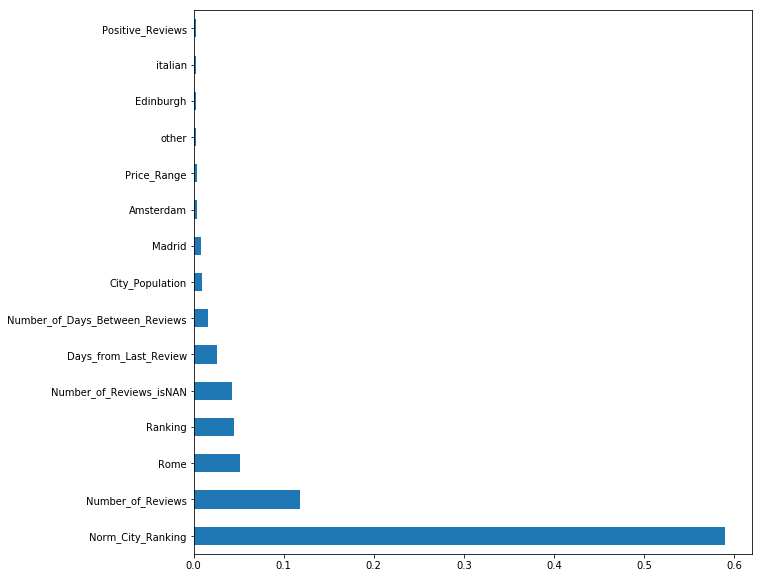

In [80]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [81]:
test_data.sample(10)

,chilean,chinese,ethiopian,irish,eastern european,diner,Geneva,korean,greek,barbecue,...,delicatessen,scandinavian,caribbean,ecuadorean,London,street food,ukrainian,latvian,mongolian,halal
9865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4419,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [82]:
test_data = test_data.drop(['Rating'], axis=1)

In [83]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [84]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [85]:
predict_submission = list(map(lambda x: round(x * 2) / 2, predict_submission))

In [86]:
len(sample_submission)

10000

In [87]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
